Multistyle transfer

In [3]:
def clip_0_1(image):
    return tf.clip_by_value(image, 0.0, 1.0)


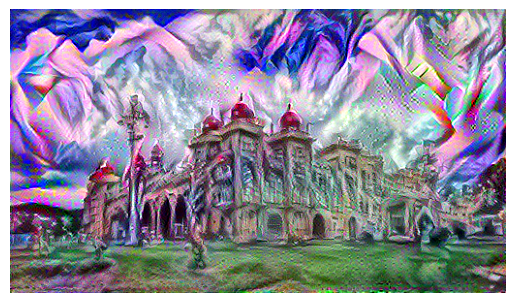

In [ ]:
import tensorflow as tf
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg19

# Define utility functions
def load_img(path_to_img, max_dim=512):
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

# Load style images and blend them
style_paths = [r"C:\Users\user\Downloads\pexels-anniroenkae-2983141.png", r"C:\Users\user\Downloads\v1_txt.png"]  # Replace with paths to style images
style_images = [load_img(style_path) for style_path in style_paths]

# VGG Model Setup
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def vgg_layers(layer_names):
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

# Feature extraction model
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = outputs[:self.num_style_layers], outputs[self.num_style_layers:]
        style_outputs = [self.gram_matrix(style_output) for style_output in style_outputs]
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}
        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        return {'content': content_dict, 'style': style_dict}

    @staticmethod
    def gram_matrix(input_tensor):
        result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
        input_shape = tf.shape(input_tensor)
        num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
        return result / num_locations

# Blend styles
extractor = StyleContentModel(style_layers, content_layers)
style_targets = [extractor(style_image)['style'] for style_image in style_images]

def blend_styles(style_outputs_list, weights=None):
    if weights is None:
        weights = [1 / len(style_outputs_list)] * len(style_outputs_list)
    blended_style = {}
    for style_layer in style_layers:
        blended_style[style_layer] = sum(weights[i] * style_outputs_list[i][style_layer]
                                         for i in range(len(style_outputs_list)))
    return blended_style

blended_style_targets = blend_styles(style_targets, weights=[0.5, 0.5])  # Adjust weights for blending

# Load content image
content_path = r"C:\Users\user\Downloads\Mysuru-Palace-banner.png"  
content_image = load_img(content_path)
content_targets = extractor(content_image)['content']

# Optimizer and loss weights
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight = 1e-2
content_weight = 1e4
total_variation_weight = 30

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - blended_style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    return style_loss + content_loss

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight * tf.image.total_variation(image)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

image = tf.Variable(content_image)

epochs = 6
steps_per_epoch = 50

for n in range(epochs):
    for m in range(steps_per_epoch):
        train_step(image)

# Display result
result_image = tensor_to_image(image)
plt.imshow(result_image)
plt.imshow(content_image)
plt.axis("off")
plt.show()


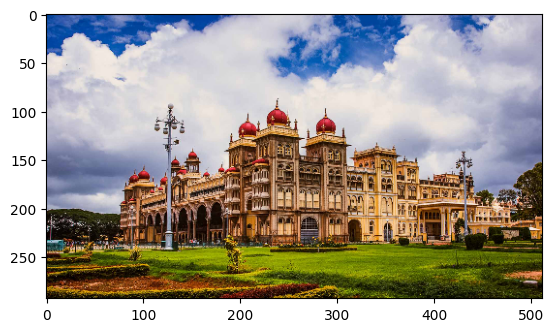

In [12]:
plt.imshow(tensor_to_image(content_image))

plt.show()

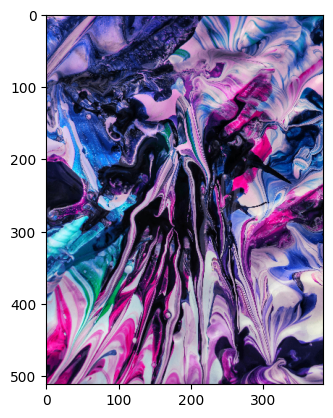

In [14]:
plt.imshow(tensor_to_image(style_images[0]))
plt.show()
